# MNIST For ML Beginners: The Bayesian way
(c) 2017 Sreekumar Thaithara Balan, Alpha-I 

This tutorial is intended for readers who are new to machine learning, TensorFlow and **Bayesian Methods**. Our intension is to created a Bayesian companion to the well known getting [started example](https://www.tensorflow.org/get_started/mnist/beginners) in TensorFlow. The readers are highly recommened to read that tutorial as a prerequisite to this blog. 

## About this tutorial
In thi tutorial, you will learn about

+ Construct a Bayesian model for classification of MNIST images
+ See how the Bayesain networks can quantify uncertainties in prediction

*For those who are eager to see why we care about uncertainites, scroll down to the bottom of this blog where we input the image of the letter "A" and ask our model to classify it. With Bayesian models we can see how confident we are about our predictions!*

## Importing data
Let us import the [MNIST images](http://yann.lecun.com/exdb/mnist/) using the builtin tensorflow methods.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True) 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Constructing a Bayesian probabilistic model

The next step in our analysis is to construct a Bayesain model. For this purpose we use a framework called [Edward](http://edwardlib.org/). It is built on top of Tensorflow and hence we can easily add a proabilistic programming using TensorFlow like constructs. 

Our machine learning model is a simple softmax regression described in the Tensorflow getting started example. The only difference here is that we need to think in terms of proabilities. Therefore each parameter in our model have a probabilty distribution attached to it. Finally we need to assign a likelihood to the observed data. Corresponding to a softmax regression, we use a Categorical likelihood function. 

In [3]:
N = 100  # number of data points
D = 784   # number of features
K = 10    # number of classes

In [4]:
x = tf.placeholder(tf.float32, [None, D])
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
y = Categorical(tf.matmul(x,w)+b)

## Making inferences

Now that we have the model defined, we can ask the model to perform statistical inference. In a Bayesian paradigm, our inference about the parameters after we have observed the data should based on the posterior distribution. Our first task to charactersise the posterior distribution. In this example we will be using Vairational Inference to perform this task.

In [5]:
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K])))) 
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [6]:
y_ph = tf.placeholder(tf.int32, [N])
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})

In [7]:
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

Now we are ready for the VI. We load upa TensorFlow session and start the iterations. This may take a few minutes...

In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 34945.836

## Evaluating Our Model
We have everything that we need to run our model on the test data. Let us load up the test data and see how good our model is. The major differnce in Bayesian modelling is that there is no single weight that we should use to evaluate the model. Instead we should use the distribution of weights and biases in our model so that the unvertainties in these parameters are reflected ont the final prediction. So instead of a single prediction we get a set of predictions and their accuracies.

We draw a few samples from the posterior distribution and see how we preform on each of these samples. Taking samples might a slow process, may take few seconds!

In [10]:
X_test = mnist.test.images
Y_test = np.argmax(mnist.test.labels,axis=1)

In [11]:
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

(array([  2.,   3.,   3.,   7.,  13.,  15.,  21.,  21.,  11.,   4.]),
 array([ 89.39 ,  89.605,  89.82 ,  90.035,  90.25 ,  90.465,  90.68 ,
         90.895,  91.11 ,  91.325,  91.54 ]),
 <a list of 10 Patch objects>)

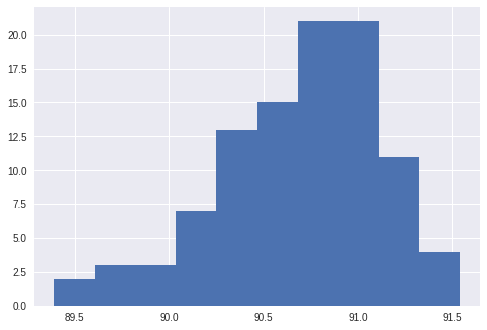

In [12]:
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)

As we can see we have a range of uncertainties. We can perform a model averaging and try to get a equivalnt of classical machine learning model.

In [13]:
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

accuracy in predicting the test data =  92.44


We should also look at the posterior distribution. Unfortunately this is really **big** even for a small problem like this. This is where Bayesian methods show their "weekness". We look at the frist 5 dimensions and produce a triangle plot of the correlations. 

/home/sbalan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


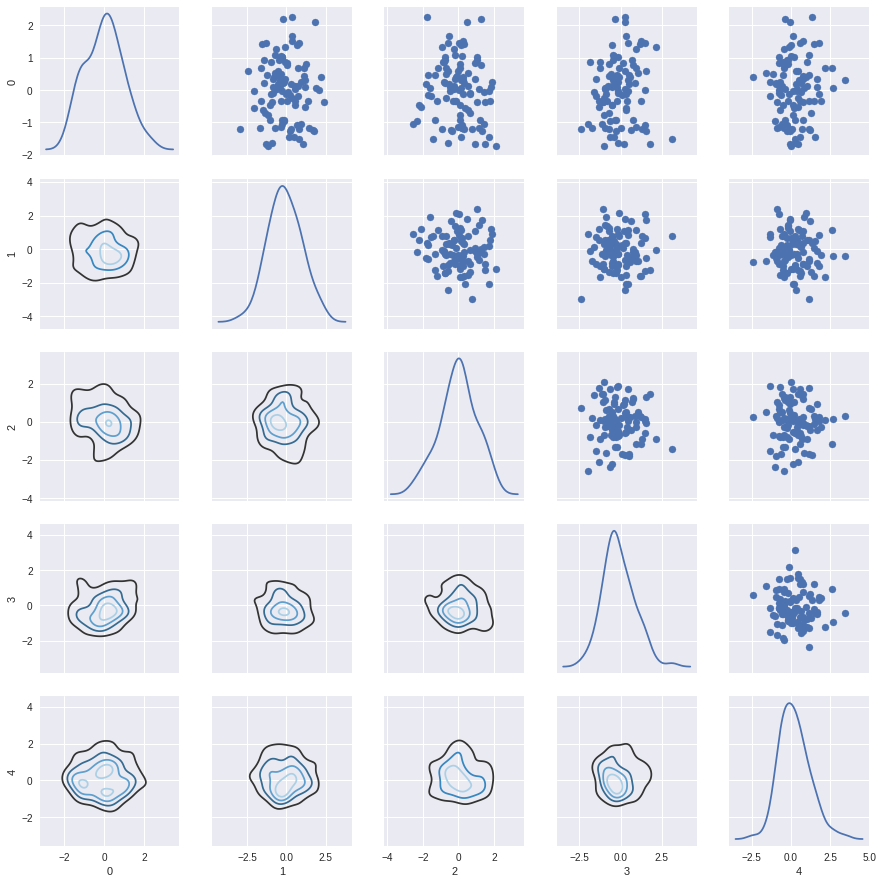

In [14]:
samples_df = pd.DataFrame(data = samples, index=range(n_samples))
g = sns.PairGrid(samples_df[list(range(5))], diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot)


## Does the model know when it doen't know?

We borrow the phrase from Yerin Gal and see if we can get a sense of uncertainty in the prediction. We load up an image from the test data and see what classification we get for each sample from the posterior distribution of weights and biases.

truth =  7


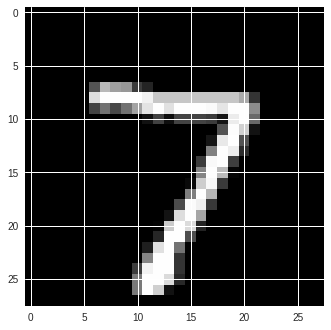

In [15]:
test_image = X_test[0:1]
test_label = Y_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='gray')

In [16]:
sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( X_test[0:1],w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())


(0, 10)

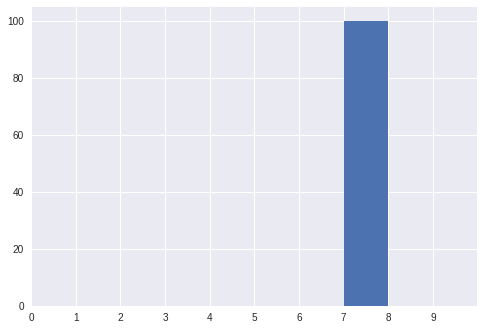

In [17]:
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)

As we can see it is very confident about the prediction here. For almost all the samples from the posterior, we can predict the true value. 

What will the model tell us if the we give a completely differnent data to that we have used for training. This a crucial test as we need to know not only a prediction but also the confidence with which we can claim that prediction. In many AI applications this information extremely valuable. 

Let us load up the notMNIST data of alphabets and see how our model reacts to this data. We can dowload the images from [here](http://yaroslavvb.com/upload/notMNIST/). The conversion to MNIST format is described [here](https://github.com/davidflanagan/notMNIST-to-MNIST). In this example we just use the converted data. I assume that all the required files are in the `notMNISt` folder and use the TensorFlow methods.

    git clone git@github.com:davidflanagan/notMNIST-to-MNIST.git
    mkdir notMNIST_data
    cp notMNIST-to-MNIST/*.gz notMNIST_data



In [18]:
not_mnist = input_data.read_data_sets("./notMNIST_data/", one_hot=True)

Extracting ./notMNIST_data/train-images-idx3-ubyte.gz
Extracting ./notMNIST_data/train-labels-idx1-ubyte.gz
Extracting ./notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./notMNIST_data/t10k-labels-idx1-ubyte.gz


In [19]:
Xnm_test = not_mnist.test.images
Ynm_test = np.argmax(not_mnist.test.labels,axis=1)

Let us now load an image from this data and ask the model to classify it. As always we a set of samples from the posterior to preform the classifcations to see how confident our model is about the prediction.

truth =  3


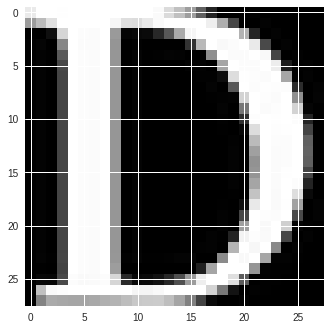

In [20]:
test_image = Xnm_test[0]
test_label = Ynm_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='gray')

In [21]:
nm_sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( Xnm_test[0:1],w_samp ) + b_samp)
    nm_sing_img_probs.append(prob.eval())


(0, 10)

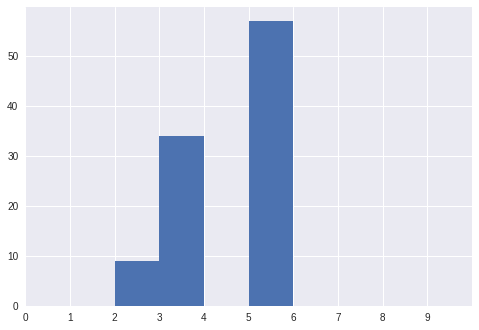

In [22]:
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)

As we can see the model is not as confident as before about the data. This where the Bayesian methods can add a lot of value compared to the traditional ML mehtod.

In [23]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,edward,tensorflow,seaborn,matplotlib

CPython 3.6.0
IPython 5.1.0

numpy 1.12.1
scipy 0.18.1
pandas 0.19.2
edward 1.3.1
tensorflow 1.1.0
seaborn 0.7.1
matplotlib 2.0.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.8.0-49-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
